<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Physics_Detailed_Particle_Type_Classification_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Three particle types classification

In this notebook, we attempt to classify three particle types: electron, muon and proton.

We use a slimmed down dataset of a public dataset from the [Deep Learn Physics Challenge](http://deeplearnphysics.org/DataChallenge/). The dataset is a set of images of three types particles (electron, muon and proton) projected in the xy-plane.


In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Physics')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Physics/"
files_to_download = ["phy_cls3_train.h5","phy_cls3_test.h5"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

Our data are stored in the hdf files physics/phy_cls3_train.h5 and physics/phy_cls3_train.h5 containing 15,000 and 3,000 images, respectively. Images are three types particles (electron, muon and proton) projected in the xy-plane. 'phy_cls3_train.h5' includes 5,000 images per particle type and 'phy_cls3_train.h5' includes 1,000 images per particle type.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# load dataset
with h5py.File(join(data_path, 'Physics/phy_cls3_train.h5'), 'r') as F:

    # downsample images to fit in memory
    x_train = np.array(F['images'][:, ::2, ::2])
    x_train = np.expand_dims(x_train, axis = -1)
    x_train = x_train.astype(np.float32)
    x_train = x_train/255.
    y_train = np.array(F['labels'])
    y_train = y_train.astype(np.float32)
    

with h5py.File(join(data_path, 'Physics/phy_cls3_test.h5'), 'r') as F:

    # downsample images to fit in memory
    x_test = np.array(F['images'][:, ::2, ::2])
    x_test = np.expand_dims(x_test, axis = -1)
    x_test = x_test.astype(np.float32)
    x_test =x_test/255.   
    y_test = np.array(F['labels'])
    y_test = y_test.astype(np.float32)
    

# string labels
string_labels = ['electron', 'muon', 'proton']

# print info
print("Number of training data: %d" % len(y_train))
print("Number of test data: %d" % len(y_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))
print("Number of labels: %s" % len(string_labels))
```
    
</p>
</details>

In [4]:
# load dataset
with h5py.File(join(data_path, 'Physics/phy_cls3_train.h5'), 'r') as F:

    # downsample images to fit in memory
    x_train = np.array(F['images'][:, ::2, ::2])
    x_train = np.expand_dims(x_train, axis = -1)
    x_train = x_train.astype(np.float32)
    x_train = x_train/255.
    y_train = np.array(F['labels'])
    y_train = y_train.astype(np.float32)


with h5py.File(join(data_path, 'Physics/phy_cls3_test.h5'), 'r') as F:

    # downsample images to fit in memory
    x_test = np.array(F['images'][:, ::2, ::2])
    x_test = np.expand_dims(x_test, axis = -1)
    x_test = x_test.astype(np.float32)
    x_test =x_test/255.
    y_test = np.array(F['labels'])
    y_test = y_test.astype(np.float32)


# string labels
string_labels = ['electron', 'muon', 'proton']

# print info
print("Number of training data: %d" % len(y_train))
print("Number of test data: %d" % len(y_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))
print("Number of labels: %s" % len(string_labels))

Number of training data: 15000
Number of test data: 3000
Image pixels: (128, 128, 1)
Number of channels: 1
Number of labels: 3


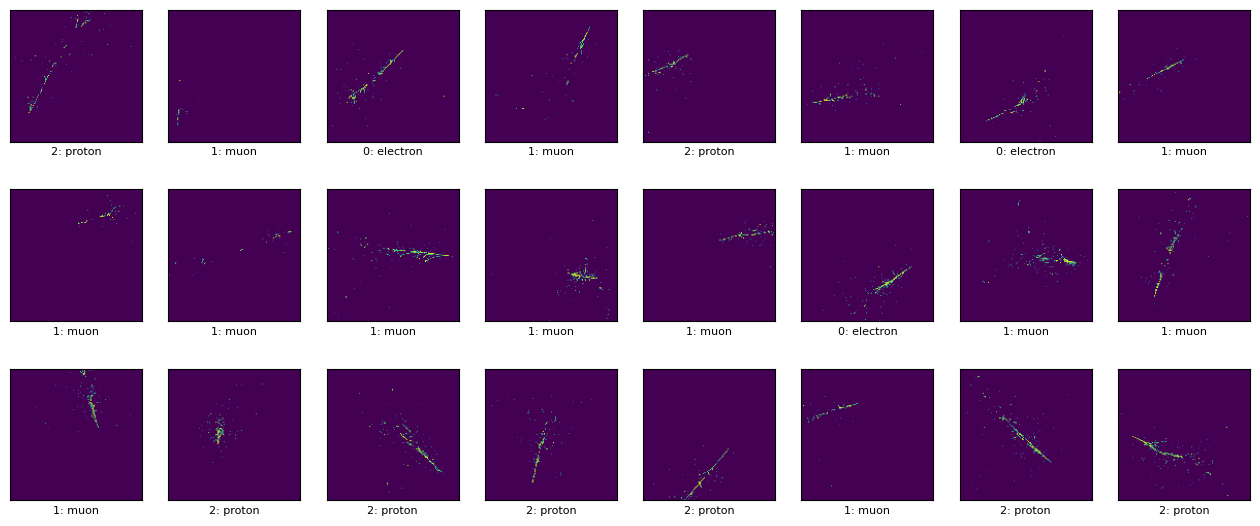

In [5]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image.squeeze())
    plt.xlabel(label, c='k', fontsize=8)
    plt.title(label2, c=label2_color, fontsize=8, y=-0.33)
    plt.xticks([])
    plt.yticks([])

# ramdomly plot some images and their labels
nrows = 3
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(y_train), nrows * ncols)):
    label = "%d: %s" % (y_train[idata], string_labels[int(y_train[idata])])
    subplot_image(x_train[idata], label, nrows, ncols, iplot)
plt.show()

---

# 2. Build the network

The inputs are 2D images. Therefore, we build a network with 2D convolutional layers.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the network architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), strides = 1, input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(256, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dense(3, activation='softmax'))

# print summary
model.summary()
```
    
</p>
</details>

In [6]:
# build the network architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), strides = 1, input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(256, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dense(3, activation='softmax'))

# print summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        27,651 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,411 (1.59 MB)

 Trainable params: 416,451 (1.59 MB)

 Non-trainable params: 960 (3.75 KB)

### Compile and train the model

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# optimizer, loss, metrics
opt = tf.keras.optimizers.RMSprop()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model

history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                             validation_data=(x_test, y_test))
```
    
</p>
</details>

In [7]:
# optimizer, loss, metrics
opt = tf.keras.optimizers.RMSprop()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model

history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                             validation_data=(x_test, y_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.3444 - loss: 2.2800 - val_accuracy: 0.3473 - val_loss: 1.1207
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.3407 - loss: 1.3440 - val_accuracy: 0.3327 - val_loss: 1.1964
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.3489 - loss: 1.1451 - val_accuracy: 0.3447 - val_loss: 1.1270
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.3814 - loss: 1.1129 - val_accuracy: 0.3393 - val_loss: 1.1604
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4152 - loss: 1.0918 - val_accuracy: 0.3403 - val_loss: 1.1774
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4484 - loss: 1.0567 - val_accuracy: 0.3287 - val_loss: 1.2093
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4991 - loss: 1.0079 - val_accuracy: 0.3320 - val_loss: 1.2136
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5591 - loss: 0.9284 - 

---

# 3. Analyse results

### Plot training history

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history[acc_str], label='Accuracy on training data')
plt.plot(history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss on training data')
plt.plot(history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

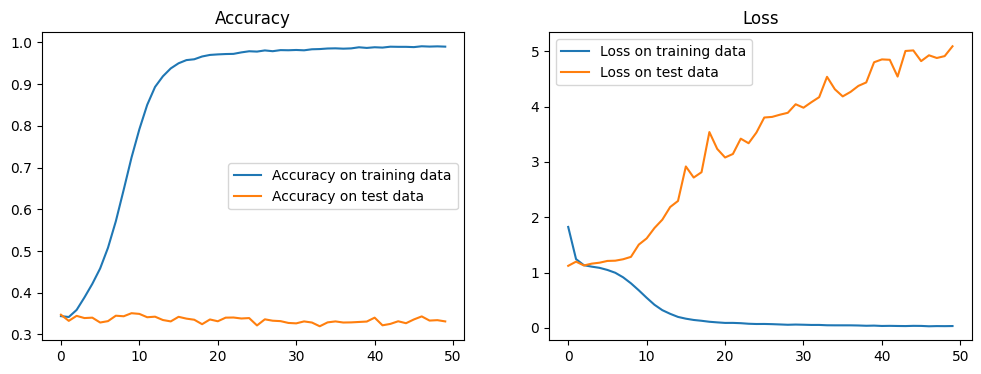

In [8]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history[acc_str], label='Accuracy on training data')
plt.plot(history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss on training data')
plt.plot(history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()

### Make predictions

In [9]:
# use test images to predict
pred_lables = model.predict(x_test).argmax(axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


Number of test data: 3000
Number of wrong predictions: 2006


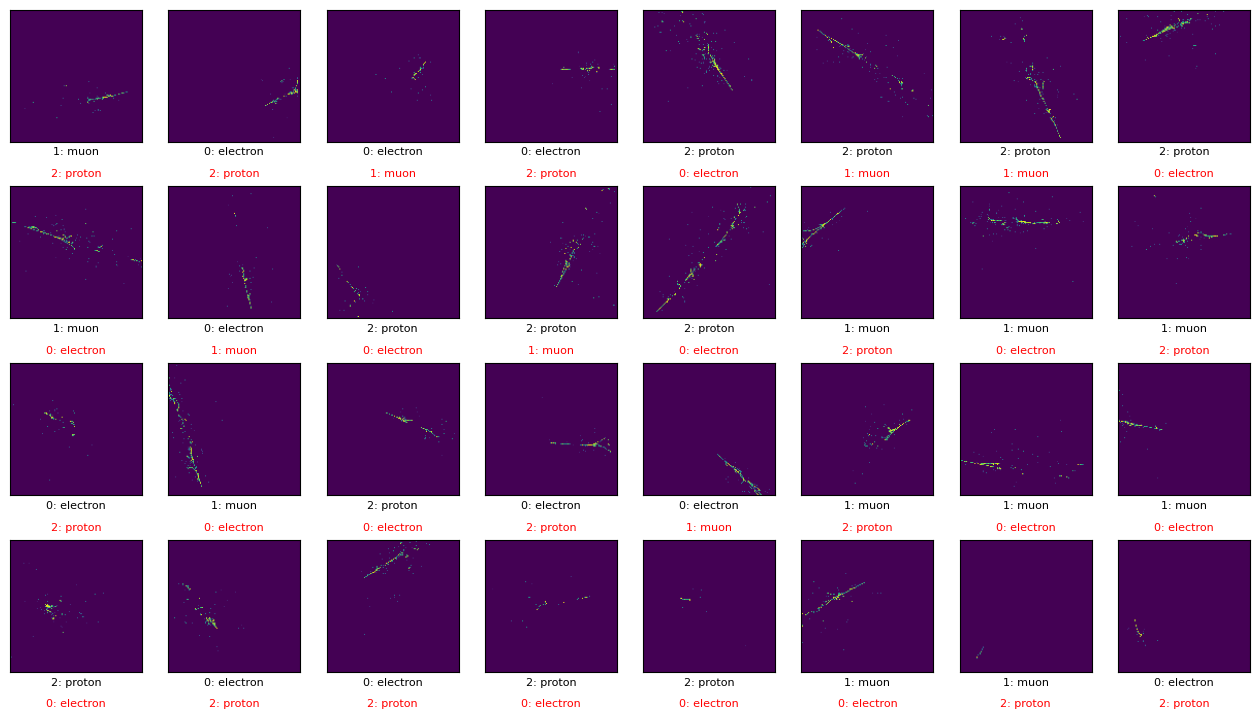

In [10]:
# get the indices of wrong predictions
id_wrong = np.where(pred_lables != y_test)[0]
print("Number of test data: %d" % y_test.size)
print("Number of wrong predictions: %d" % id_wrong.size)

# plot the wrong predictions
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(id_wrong, nrows * ncols)):
    label = "%d: %s" % (y_test[idata], string_labels[int(y_test[idata])])
    label2 = "%d: %s" % (pred_lables[idata], string_labels[pred_lables[idata]])
    subplot_image(x_test[idata], label, nrows, ncols, iplot, label2, 'r')
plt.show()

---

# 4. Exercises


Notice that the accuracies for the training and the test data diverge as the model trains. This is a classic symptom of [overfitting](https://en.wikipedia.org/wiki/Overfitting), that is, our model corresponds too closely to the training data so that it cannot fit the test data with an equivalent accuracy.

* Add more convolutional layers
* Regularise the network and re-train